In [1]:
# import libraries

import pandas as pd
import numpy as np
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn import metrics
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import pickle
import warnings
warnings.filterwarnings('ignore')
from flaml import AutoML

In [2]:
# read data

pd.set_option('display.max_columns',None)
df=pd.read_csv('preprocessed.csv')
df

,Date,Location,MinTemp,MaxTemp,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Cloud9am,Cloud3pm,RainToday,RainTomorrow,Year,Month,Season
0,1.0,30.0,13.4,22.900000,6.493419,7.549565,4.000000,44.000000,4.0,2.0,20.0,24.0,71.0,22.0,1007.7,8.000000,5.274353,0,0,2008.0,12.0,1.0
1,2.0,30.0,7.4,25.100000,6.557349,11.643941,2.000000,44.000000,0.0,5.0,4.0,22.0,44.0,25.0,1010.6,1.941410,2.637223,0,0,2008.0,12.0,1.0
2,3.0,30.0,12.9,25.700000,8.922124,12.365480,5.000000,46.000000,4.0,5.0,19.0,26.0,38.0,30.0,1007.6,2.103591,2.000000,0,0,2008.0,12.0,1.0
3,4.0,30.0,9.2,28.000000,7.254362,12.675248,11.000000,24.000000,12.0,15.0,11.0,9.0,45.0,16.0,1017.6,1.218062,1.698868,0,0,2008.0,12.0,1.0
4,5.0,30.0,17.5,32.300000,7.079074,6.529833,4.000000,41.000000,14.0,1.0,7.0,20.0,82.0,33.0,1010.8,7.000000,8.000000,0,0,2008.0,12.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,21.0,49.0,2.8,23.400000,5.826071,10.455246,15.000000,31.000000,12.0,14.0,13.0,11.0,51.0,24.0,1024.6,1.509480,2.057882,0,0,2017.0,6.0,3.0
145456,22.0,49.0,3.6,25.300000,5.039491,9.960972,0.000000,22.000000,12.0,3.0,13.0,9.0,56.0,21.0,1023.5,1.938709,2.596119,0,0,2017.0,6.0,3.0
145457,23.0,49.0,5.4,26.900000,6.070340,9.548692,3.000000,37.000000,12.0,2.0,9.0,9.0,53.0,24.0,1021.0,2.246382,2.998410,0,0,2017.0,6.0,3.0
145458,24.0,49.0,7.8,27.000000,6.712732,10.061661,12.000000,28.000000,10.0,3.0,13.0,7.0,51.0,24.0,1019.4,3.000000,2.000000,0,0,2017.0,6.0,3.0


In [3]:
# split data

X=df.drop(labels=['RainTomorrow','Date','Year'],axis=1)
y=df['RainTomorrow']

X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y,random_state=2)

In [4]:
# oversampling data

sm=SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_res)))

The number of classes before fit Counter({0: 84765, 1: 24330})
The number of classes after fit Counter({0: 84765, 1: 84765})


In [5]:
# train model

def run_model(model):
    model=model
    model.fit(X_train_res,y_train_res)
    prediction=model.predict(X_test)

    print('TRAIN SCORE \n \n',model.score(X_train_res,y_train_res))
    print('-----------------------------------------------------------------')  
    print('TEST SCORE \n \n',model.score(X_test,y_test))
    print('-----------------------------------------------------------------') 
    print('CONFUSION MATRIX \n \n',metrics.confusion_matrix(y_test,prediction))
    print('-----------------------------------------------------------------')
    print('CLASSIFICATION REPORT \n \n',metrics.classification_report(y_test,prediction))
    print('-----------------------------------------------------------------')
    print('ROC AUC SCORE \n \n',metrics.roc_auc_score(y_test, prediction, average=None))
    print('-----------------------------------------------------------------')
    metrics.plot_roc_curve(model, X_test, y_test)
    return pd.DataFrame({'ACTUAL':y_test,'PREDICTED':prediction})

TRAIN SCORE 
 
 0.7997463575768301
-----------------------------------------------------------------
TEST SCORE 
 
 0.7997525092809019
-----------------------------------------------------------------
CONFUSION MATRIX 
 
 [[22597  5658]
 [ 1624  6486]]
-----------------------------------------------------------------
CLASSIFICATION REPORT 
 
               precision    recall  f1-score   support

           0       0.93      0.80      0.86     28255
           1       0.53      0.80      0.64      8110

    accuracy                           0.80     36365
   macro avg       0.73      0.80      0.75     36365
weighted avg       0.84      0.80      0.81     36365

-----------------------------------------------------------------
ROC AUC SCORE 
 
 0.7997528235566482
-----------------------------------------------------------------


,ACTUAL,PREDICTED
130924,0,0
5573,0,0
79223,1,1
126128,0,0
39797,0,0
...,...,...
98905,0,0
1983,0,0
65904,0,1
56745,1,1


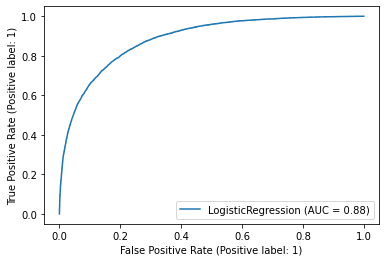

In [6]:
# logistic regression

lr=LogisticRegression(n_jobs=5)
run_model(lr)

In [9]:
# time for automl 

automl=AutoML()
automl_settings={"time_budget": 200,
            "metric": 'accuracy',
            "task": 'classification',
            "log_file_name": 'rain.log'}

automl.fit(X_train=X_train_res,y_train=y_train_res,**automl_settings,X_val=X_test,y_val=y_test,n_splits=7)

[flaml.automl: 01-13 09:20:02] {1432} INFO - Evaluation method: holdout
[flaml.automl: 01-13 09:20:02] {1478} INFO - Minimizing error metric: 1-accuracy
[flaml.automl: 01-13 09:20:02] {1515} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'lrl1']
[flaml.automl: 01-13 09:20:02] {1748} INFO - iteration 0, current learner lgbm
[flaml.automl: 01-13 09:20:02] {1865} INFO - Estimated sufficient time budget=5923s. Estimated necessary time budget=108s.
[flaml.automl: 01-13 09:20:02] {1938} INFO -  at 0.5s,	estimator lgbm's best error=0.2455,	best estimator lgbm's best error=0.2455
[flaml.automl: 01-13 09:20:02] {1748} INFO - iteration 1, current learner lgbm
[flaml.automl: 01-13 09:20:02] {1938} INFO -  at 0.5s,	estimator lgbm's best error=0.2455,	best estimator lgbm's best error=0.2455
[flaml.automl: 01-13 09:20:02] {1748} INFO - iteration 2, current learner lgbm
[flaml.automl: 01-13 09:20:02] {1938} INFO -  at 0.6s,	estimator lgbm's best error=0.

[flaml.automl: 01-13 09:20:08] {1938} INFO -  at 7.1s,	estimator catboost's best error=0.1407,	best estimator catboost's best error=0.1407
[flaml.automl: 01-13 09:20:08] {1748} INFO - iteration 37, current learner extra_tree
[flaml.automl: 01-13 09:20:08] {1938} INFO -  at 7.1s,	estimator extra_tree's best error=0.2118,	best estimator catboost's best error=0.1407
[flaml.automl: 01-13 09:20:08] {1748} INFO - iteration 38, current learner catboost
[flaml.automl: 01-13 09:20:10] {1938} INFO -  at 8.6s,	estimator catboost's best error=0.1407,	best estimator catboost's best error=0.1407
[flaml.automl: 01-13 09:20:10] {1748} INFO - iteration 39, current learner xgboost
[flaml.automl: 01-13 09:20:10] {1938} INFO -  at 8.7s,	estimator xgboost's best error=0.2289,	best estimator catboost's best error=0.1407
[flaml.automl: 01-13 09:20:10] {1748} INFO - iteration 40, current learner rf
[flaml.automl: 01-13 09:20:10] {1938} INFO -  at 8.8s,	estimator rf's best error=0.2056,	best estimator catboost

[flaml.automl: 01-13 09:20:42] {1748} INFO - iteration 74, current learner extra_tree
[flaml.automl: 01-13 09:20:42] {1938} INFO -  at 40.6s,	estimator extra_tree's best error=0.2118,	best estimator lgbm's best error=0.1061
[flaml.automl: 01-13 09:20:42] {1748} INFO - iteration 75, current learner xgboost
[flaml.automl: 01-13 09:20:42] {1938} INFO -  at 40.9s,	estimator xgboost's best error=0.1769,	best estimator lgbm's best error=0.1061
[flaml.automl: 01-13 09:20:42] {1748} INFO - iteration 76, current learner extra_tree
[flaml.automl: 01-13 09:20:42] {1938} INFO -  at 41.0s,	estimator extra_tree's best error=0.1955,	best estimator lgbm's best error=0.1061
[flaml.automl: 01-13 09:20:42] {1748} INFO - iteration 77, current learner lgbm
[flaml.automl: 01-13 09:20:45] {1938} INFO -  at 44.0s,	estimator lgbm's best error=0.1061,	best estimator lgbm's best error=0.1061
[flaml.automl: 01-13 09:20:45] {1748} INFO - iteration 78, current learner lgbm
[flaml.automl: 01-13 09:21:02] {1938} INFO

[flaml.automl: 01-13 09:22:39] {1938} INFO -  at 158.1s,	estimator catboost's best error=0.1198,	best estimator lgbm's best error=0.0973
[flaml.automl: 01-13 09:22:39] {1748} INFO - iteration 112, current learner lgbm
[flaml.automl: 01-13 09:23:01] {1938} INFO -  at 179.6s,	estimator lgbm's best error=0.0973,	best estimator lgbm's best error=0.0973
[flaml.automl: 01-13 09:23:01] {1748} INFO - iteration 113, current learner lrl1
[flaml.automl: 01-13 09:23:01] {1938} INFO -  at 179.8s,	estimator lrl1's best error=0.2081,	best estimator lgbm's best error=0.0973
[flaml.automl: 01-13 09:23:01] {1748} INFO - iteration 114, current learner extra_tree
[flaml.automl: 01-13 09:23:01] {1938} INFO -  at 179.9s,	estimator extra_tree's best error=0.1669,	best estimator lgbm's best error=0.0973
[flaml.automl: 01-13 09:23:01] {1748} INFO - iteration 115, current learner lrl1
[flaml.automl: 01-13 09:23:01] {1938} INFO -  at 180.2s,	estimator lrl1's best error=0.2076,	best estimator lgbm's best error=0.

TRAIN SCORE 
 
 1.0
-----------------------------------------------------------------
TEST SCORE 
 
 0.9026536504881068
-----------------------------------------------------------------
CONFUSION MATRIX 
 
 [[27039  1216]
 [ 2324  5786]]
-----------------------------------------------------------------
CLASSIFICATION REPORT 
 
               precision    recall  f1-score   support

           0       0.92      0.96      0.94     28255
           1       0.83      0.71      0.77      8110

    accuracy                           0.90     36365
   macro avg       0.87      0.84      0.85     36365
weighted avg       0.90      0.90      0.90     36365

-----------------------------------------------------------------
ROC AUC SCORE 
 
 0.8352017833012326
-----------------------------------------------------------------


,ACTUAL,PREDICTED
130924,0,0
5573,0,0
79223,1,0
126128,0,0
39797,0,0
...,...,...
98905,0,0
1983,0,0
65904,0,0
56745,1,1


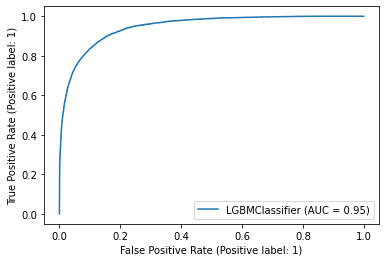

In [11]:


lgbm=LGBMClassifier(colsample_bytree=0.6080131353149313,
               learning_rate=0.06735753867426866, max_bin=64,
               min_child_samples=3, n_estimators=2354, num_leaves=947,
               objective='binary', reg_alpha=0.2518463928879132,
               reg_lambda=0.04776524933847931, verbose=-1)
run_model(lgbm)

In [12]:
# save model

pickle.dump(lgbm,open('lgbm.pkl','wb'))

with open('lgbm.pkl', 'rb') as file:
    classifier = pickle.load(file)